# Simple classifier training with PyTorch

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 26421880/26421880 [00:01<00:00, 15843619.50it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 300806.68it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4991642.34it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10080428.10it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training set has 60000 instances
Validation set has 10000 instances


Trouser  Ankle Boot  Coat  Coat


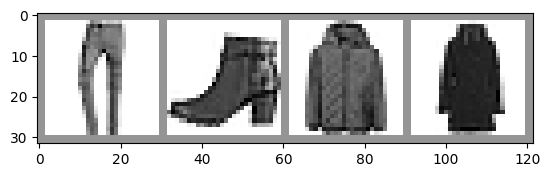

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

In [7]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.9200, 0.4430, 0.2647, 0.7559, 0.7806, 0.7152, 0.2254, 0.0032, 0.4780,
         0.8627],
        [0.9238, 0.0362, 0.2996, 0.3347, 0.8672, 0.4761, 0.3653, 0.3604, 0.8737,
         0.4046],
        [0.7425, 0.3868, 0.2024, 0.2828, 0.8592, 0.2203, 0.2945, 0.6124, 0.6137,
         0.9232],
        [0.7588, 0.7046, 0.0785, 0.1967, 0.6874, 0.8287, 0.1397, 0.3480, 0.3937,
         0.9549]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.4701645374298096


In [8]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
def train_one_epoch(epoch_index, tb_writer):

    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [10]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.8019868609011174
  batch 2000 loss: 0.8156253744438291
  batch 3000 loss: 0.7175526417549699
  batch 4000 loss: 0.6381538419160061
  batch 5000 loss: 0.5901161139835603
  batch 6000 loss: 0.5730999818528071
  batch 7000 loss: 0.5232616623127833
  batch 8000 loss: 0.5028738573959562
  batch 9000 loss: 0.49766554301988797
  batch 10000 loss: 0.49386580544593744
  batch 11000 loss: 0.4581838376026135
  batch 12000 loss: 0.43532456894626376
  batch 13000 loss: 0.4133578732048627
  batch 14000 loss: 0.4405760743670398
  batch 15000 loss: 0.42439523001947965
LOSS train 0.42439523001947965 valid 0.46092405915260315
EPOCH 2:
  batch 1000 loss: 0.3961926300723571
  batch 2000 loss: 0.38374258364457636
  batch 3000 loss: 0.38325761309615336
  batch 4000 loss: 0.3639362080995925
  batch 5000 loss: 0.38537108163611267
  batch 6000 loss: 0.37306315242004345
  batch 7000 loss: 0.3886990359680203
  batch 8000 loss: 0.3236996955879149
  batch 9000 loss: 0.3729143393186386

Pullover  Dress  Shirt  Trouser


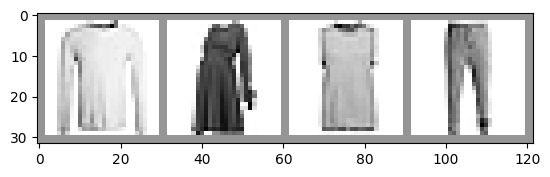

In [26]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [28]:
[classes[i] for i in model(images).argmax(axis = 1).tolist()]

['Pullover', 'Dress', 'T-shirt/top', 'Trouser']